<a href="https://colab.research.google.com/github/levhojoyan/Sirius2021/blob/main/NeuralWithWeights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
import numpy as np 
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torch import distributions as distrs


from sklearn.datasets import load_boston
from tqdm.notebook import tqdm

from IPython.display import clear_output

%matplotlib inline

Создадим искусственные данные для задачи регрессии: синус + нормальный шум


In [119]:
# Красиво рисует двумерное распределение
def plot_2d_dots(dots, color='blue', label='None'):
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.scatter(dots[:, 0], dots[:, 1], s=1, c=color, label=label)

In [120]:
sample_size = 500
# x_s = torch.empty(sample_size).normal_(mean=0,std=1).unsqueeze(1)
x_s = torch.linspace(-2 * 3.14, 2 * 3.14, 500)
noise_s = torch.empty(sample_size).normal_(mean=0,std=1)

f_s = torch.sin(x_s) # + noise_s 

sample_2d = torch.cat((x_s, f_s), 1)

print(sample_2d.shape)

torch.Size([100, 2])


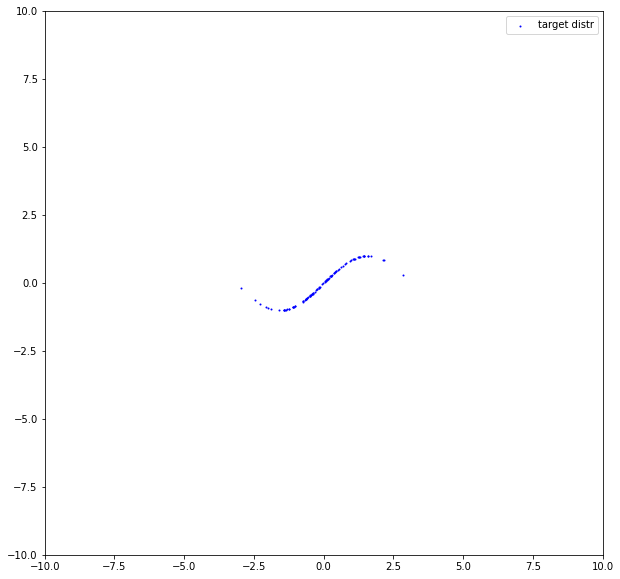

In [121]:
plt.figure(figsize=(10, 10))
plot_2d_dots(sample_2d, label='target distr')
plt.legend()
plt.show()

In [122]:
class RandomDataset(torch.utils.data.Dataset):
    """Our random dataset"""
    
    def __init__(self, x, y):
        self.x, self.y = x, y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return {'sample': torch.tensor(self.x[idx], dtype=torch.float), 'target': self.y[idx]}

In [123]:
our_dataset = RandomDataset(x_s, f_s)
print(sample_2d.shape, x_s.shape)

torch.Size([100, 2]) torch.Size([100, 1])


In [124]:
our_dataset.__getitem__(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


{'sample': tensor([0.4074]), 'target': tensor([0.3962])}

In [125]:
sample_2d[1]

tensor([0.4074, 0.3962])

In [126]:
batch_size=16

In [127]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Linear(1, 10) # the simpliest
        # self.conv1 = nn.Linear(5, 5) # the simpliest
        self.conv2 = nn.Linear(10, 1)

    def forward(self, x):
      x = self.before_linear_mixture(x)
      return self.conv2(x)

    def before_linear_mixture(self, x):
      x = F.relu(self.conv1(x))
      return x

In [128]:
dataloader = torch.utils.data.DataLoader(our_dataset, batch_size=4)
train_size = int(sample_size * 0.7)
test_size = sample_size - train_size

In [129]:
for batch in dataloader:
    batch_x = batch['sample']
    batch_y = batch['target']
    break
print('Sample:', batch_x)
print('Target:', batch_y)

print(batch_x.shape)
y_pred = model(batch_x) # получили предсказания модели
loss = torch.nn.MSELoss()(batch_y, y_pred)
print(loss.data, y_pred)

Sample: tensor([[ 0.9575],
        [ 0.4074],
        [-1.3332],
        [ 0.9769]])
Target: tensor([[ 0.8177],
        [ 0.3962],
        [-0.9719],
        [ 0.8287]])
torch.Size([4, 1])
tensor(0.0042) tensor([[ 0.7646],
        [ 0.3878],
        [-0.8697],
        [ 0.7706]], grad_fn=<AddmmBackward>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


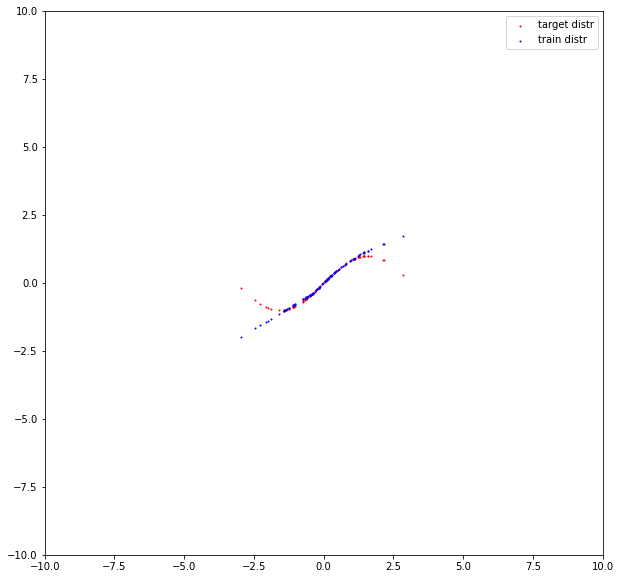

In [130]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
mses = []

i = 0
for epoch in range(11):
  for x_train, y_train in tqdm(dataloader): # берем батч из трейн лоадера
      x_train = batch['sample']
      y_train = batch['target']

      print(x_train)
      y_pred = model(x_train) # делаем предсказания
      loss = torch.nn.MSELoss()(y_pred, y_train) # считаем лосс
      loss.backward() # считаем градиенты обратным проходом
      optimizer.step() # обновляем параметры сети
      optimizer.zero_grad() # обнуляем посчитанные градиенты параметров
      i += 1

      mses.append(loss)

      if i % 5 == 0:
        # plot pdfs
        clear_output(True)
        plt.figure(figsize=(10, 10))

        total_pred = model(x_s.unsqueeze(1))
        total_pred.detach_()
        # print(x_s.shape, total_pred.shape)

        plot_2d_dots(sample_2d, color='r', label='target distr')
        plot_2d_dots(torch.cat((x_s.unsqueeze(1), total_pred), 1), color='b', label='train distr')
        plt.legend()
        plt.show() 

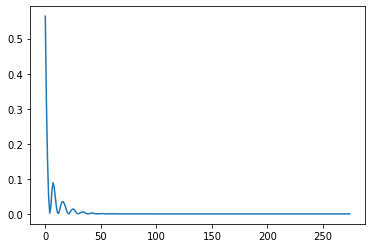

In [132]:
plt.plot(mses)

In [154]:
class ModelWithWeighted(nn.Module):
    def __init__(self):
        super(ModelWithWeighted, self).__init__()
        self.conv1 = nn.Linear(1, 10) # the simpliest
        # self.conv1 = nn.Linear(5, 5) # the simpliest

    def forward(self, x):
      x = F.softsign(self.conv1(x))
      return x

In [155]:
list(model.conv2.parameters())


[Parameter containing:
 tensor([[-0.1038, -0.2158,  0.2281,  0.0497, -0.3944,  0.3391,  0.5221, -0.2580,
          -0.2008, -0.2927]], requires_grad=True), Parameter containing:
 tensor([0.0728], requires_grad=True)]

In [156]:
model2 = ModelWithWeighted()
last_layer_weights = torch.zeros(10, requires_grad=True)

optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.05)
optimizer2.add_param_group({'params':last_layer_weights})


In [157]:
model2.parameters()

<generator object Module.parameters at 0x7f1617af03d0>

torch.Size([100, 1]) torch.Size([100, 1])


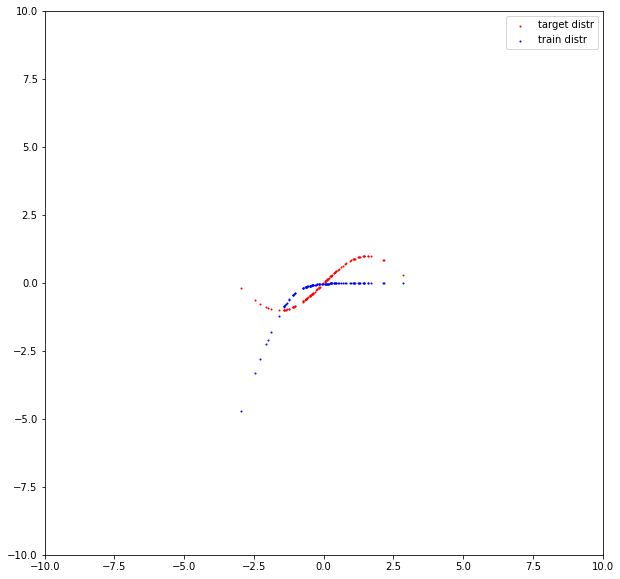

In [158]:

i = 0
losses = []
mses = []
weighted_mses = []
for epoch in range(11):
  for x_train, y_train in tqdm(dataloader): # берем батч из трейн лоадера
      x_train = batch['sample']
      y_train = batch['target']

      norm_weights = F.softmax(last_layer_weights)
      y_pred_functions = model2(x_train) # до последнего слоя

      weighted_mse = torch.sum(norm_weights * ((y_pred_functions - y_train)**2)) # считаем взвешенное мсе


      y_pred = torch.sum(y_pred_functions * norm_weights, dim=-1) # делаем сквозь всю сетку

      print(y_pred.shape)

      mse = torch.nn.MSELoss()(y_pred, y_train) # считаем лосс


      total_loss = mse + weighted_mse # считаем лосс
      total_loss.backward() # считаем градиенты обратным проходом
      losses.append(total_loss)
      mses.append(mse)
      weighted_mses.append(weighted_mse)

      optimizer2.step() # обновляем параметры сети
      optimizer2.zero_grad() # обнуляем посчитанные градиенты параметров
      i += 1

      if i % 5 == 0:
        # plot pdfs
        clear_output(True)
        plt.figure(figsize=(10, 10))
        total_pred = torch.sum(model2(x_s.unsqueeze(1)) * norm_weights, dim=-1)
        total_pred.detach_()
        optimizer2.zero_grad()
        print(x_s.shape, total_pred.shape)

        plot_2d_dots(sample_2d, color='r', label='target distr')
        plot_2d_dots(torch.cat((x_s, total_pred), dim=1), color='b', label='train distr')
        plt.legend()
        plt.show() 


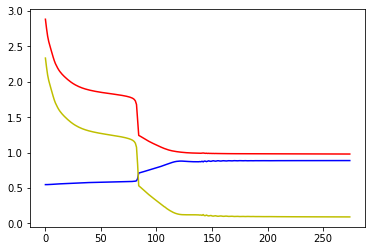

In [148]:
plt.plot(losses, color='r')
plt.plot(mses, color='b')
plt.plot(weighted_mses, color='y')

In [160]:
F.softmax(last_layer_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([0.0026, 0.0022, 0.0168, 0.0020, 0.0019, 0.0108, 0.1166, 0.1209, 0.6916,
        0.0346], grad_fn=<SoftmaxBackward>)

In [161]:
model2.conv1.weight

Parameter containing:
tensor([[0.7552],
        [0.9745],
        [1.7987],
        [1.0046],
        [1.0131],
        [1.7342],
        [2.3729],
        [2.3209],
        [3.1378],
        [2.0133]], requires_grad=True)